In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from collections import Counter
from sklearn.metrics import accuracy_score


In [2]:
df = pd.read_csv('tokenized_news_articles.csv')

X = df['tokenized_content'] 
y = df['gold_label']

# Map class labels to numerical indices
label_to_index = {label: idx for idx, label in enumerate(y.unique())}
index_to_label = {idx: label for label, idx in label_to_index.items()}
y = y.map(label_to_index)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [3]:
all_tokens = [token for tokens in X for token in eval(tokens)]  # Use eval if stored as strings
vocabulary = list(set(all_tokens))
token_to_index = {token: idx for idx, token in enumerate(vocabulary)}
vocab_size = len(vocabulary)

In [4]:

def tokens_to_vector(tokens, token_to_index, vocab_size):
    vector = np.zeros(vocab_size)
    for token in eval(tokens):  # Use eval if tokens are stored as strings in CSV
        if token in token_to_index:
            vector[token_to_index[token]] += 1
    return vector

# Convert tokenized content into feature matrices
X_train_vectors = np.array([tokens_to_vector(tokens, token_to_index, vocab_size) for tokens in X_train])
X_test_vectors = np.array([tokens_to_vector(tokens, token_to_index, vocab_size) for tokens in X_test])

In [5]:
X_train_tfidf = X_train_vectors
X_test_tfidf = X_test_vectors

num_classes = len(label_to_index)
y_train_onehot = np.eye(num_classes)[y_train]
y_test_onehot = np.eye(num_classes)[y_test]

num_features = X_train_tfidf.shape[1]
weights = np.zeros((num_features, num_classes))
biases = np.zeros(num_classes)

In [6]:
def softmax(logits):
    exp_logits = np.exp(logits - np.max(logits, axis=1, keepdims=True))
    return exp_logits / np.sum(exp_logits, axis=1, keepdims=True)

def compute_loss(y_true, y_pred):
    m = y_true.shape[0]
    return -np.sum(y_true * np.log(y_pred + 1e-15)) / m

def compute_gradients(X, y_true, y_pred):
    m = X.shape[0]
    error = y_pred - y_true
    dw = np.dot(X.T, error) / m
    db = np.sum(error, axis=0) / m
    return dw, db

In [7]:
learning_rate = 0.05
epochs = 1000
loss_history=[]
for epoch in range(epochs):
    # Forward pass
    logits = np.dot(X_train_tfidf, weights) + biases
    y_pred = softmax(logits)

    loss = compute_loss(y_train_onehot, y_pred)
    loss_history.append(loss)

    dw, db = compute_gradients(X_train_tfidf, y_train_onehot, y_pred)
    weights -= learning_rate * dw
    biases -= learning_rate * db

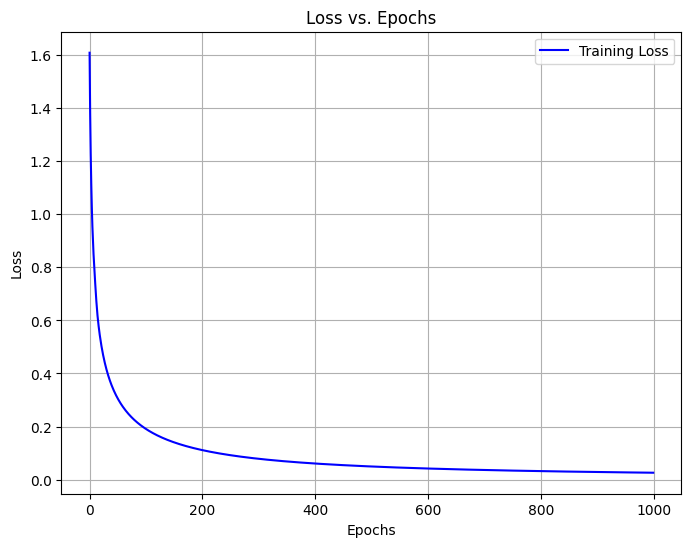

In [8]:
plt.figure(figsize=(8, 6))
plt.plot(range(epochs), loss_history, label="Training Loss", color='blue')
plt.title("Loss vs. Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

In [9]:
logits_test = np.dot(X_test_tfidf, weights) + biases
y_test_pred = np.argmax(softmax(logits_test), axis=1)

# Convert predictions back to original labels
y_test_original = [index_to_label[idx] for idx in y_test]
y_pred_original = [index_to_label[idx] for idx in y_test_pred]

print("Classification Report:")
print(classification_report(y_test_original, y_pred_original, target_names=label_to_index.keys()))
accuracy_score(y_test_original, y_pred_original)

Classification Report:
                    precision    recall  f1-score   support

     entertainment       0.99      0.96      0.97        69
          business       0.96      0.94      0.95        72
            sports       0.98      0.94      0.96        66
science-technology       0.96      0.97      0.97        72
             world       0.88      0.94      0.91        72

          accuracy                           0.95       351
         macro avg       0.95      0.95      0.95       351
      weighted avg       0.95      0.95      0.95       351



0.9515669515669516

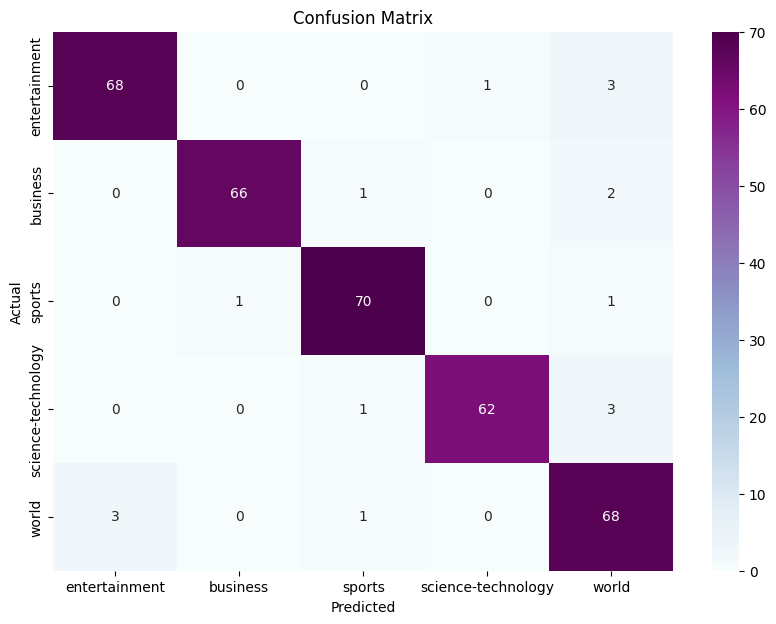

In [10]:
cm = confusion_matrix(y_test, y_test_pred)
cm_df = pd.DataFrame(cm, index=[index_to_label[i] for i in range(num_classes)], 
                          columns=[index_to_label[i] for i in range(num_classes)])

plt.figure(figsize=(10, 7))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='BuPu')
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

## SCIKIT MODEL

In [11]:
from sklearn.linear_model import LogisticRegression

df = pd.read_csv('tokenized_news_articles.csv')

X = df['content']  
y = df['gold_label']   

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

vectorizer = TfidfVectorizer(max_features=5000)  
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

model = LogisticRegression(max_iter=1000, random_state=42, multi_class='multinomial', solver='lbfgs')
model.fit(X_train_tfidf, y_train)

y_pred = model.predict(X_test_tfidf)
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['entertainment', 'business', 'sports', 'science-technology', 'world']))


C:\Users\Talha\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Classification Report:
                    precision    recall  f1-score   support

     entertainment       0.98      0.89      0.93        46
          business       0.98      0.98      0.98        48
            sports       0.93      0.98      0.96        44
science-technology       1.00      0.98      0.99        48
             world       0.92      0.98      0.95        48

          accuracy                           0.96       234
         macro avg       0.96      0.96      0.96       234
      weighted avg       0.96      0.96      0.96       234

